# Notebook 2 — Trip-level exploration and “going home” behaviour

## 1. Import the Datasets from 000

In this notebook the analysis starts from the visit-level table constructed in
Notebook 1. The file `visit_level_table_000.csv` is loaded from the `data`
folder and the basic Python environment (NumPy, pandas, Matplotlib) is set up.
Date and time fields are combined into full start and end timestamps for each
visit (`first_dt` and `last_dt`), and the user identifier is taken from the
`person` column for use in plots. The table is then sorted by person, date,
and start time to produce a clean, time-ordered record of visit events rather
than daily aggregates; subsequent sections build on this event sequence to
identify complete home–home trips (individual “outings”).



In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="DataFrameGroupBy.apply operated on the grouping columns",
    category=FutureWarning,
)

In [3]:
# 1. Environment and data loading

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

# Path to the visit-level table saved from Notebook 1
path = "data/visit_level_table_000.csv"
visit_table = pd.read_csv(path)

print("Rows in visit_table:", len(visit_table))
display(visit_table.head())

# Parse date + times into full timestamps
visit_table["date"] = pd.to_datetime(visit_table["date"]).dt.date

visit_table["first_dt"] = pd.to_datetime(
    visit_table["date"].astype(str) + " " + visit_table["first_time"]
)
visit_table["last_dt"] = pd.to_datetime(
    visit_table["date"].astype(str) + " " + visit_table["last_time"]
)

# Identify the user ID from the table
USER_ID = str(visit_table["person"].iloc[0])
print("Unique persons in this file:", visit_table["person"].unique())
print("USER_ID used in plots:", USER_ID)

# Ensure rows are ordered in time
visit_table = (
    visit_table
    .sort_values(["person", "date", "first_dt"])
    .reset_index(drop=True)
)
print("Rows in visit_table after sorting:", len(visit_table))

Rows in visit_table: 1841


,person,date,first_time,last_time,duration_min,grid_ci,grid_rj,grid_center_lon,grid_center_lat,dist_home_m,is_home,is_sw,is_pv,is_pn,place_id,next_step,visit_order_in_day,action_order
0,0,2008-10-23,03:00:55,04:13:32,72.6,40,50,116.300184,39.984308,3201.6,0,0,1,0,Pv1,sw,1,1
1,0,2008-10-23,09:42:25,09:42:30,0.1,43,55,116.317527,40.006935,500.0,0,1,0,0,SW,home,2,2
2,0,2008-10-23,09:42:35,10:05:29,22.9,44,55,116.323385,40.006970,0.0,1,0,0,0,HOME,sw,3,0
3,0,2008-10-23,10:05:34,10:30:15,24.7,43,55,116.317527,40.006935,500.0,0,1,0,0,SW,home,4,1
4,0,2008-10-23,10:30:20,11:10:57,40.6,44,55,116.323385,40.006970,0.0,1,0,0,0,HOME,none,5,0


Unique persons in this file: [0]
USER_ID used in plots: 0
Rows in visit_table after sorting: 1841


## 2. From daily visits to home–home trips

The next stage groups individual visit events into complete home-to-home trips. For each person and each day, the visit records are ordered by their start times. Any record marked is_home == 1 is treated as being at HOME. A new trip begins the moment the user leaves HOME for a non-home location, continues through any consecutive non-home stops, and ends as soon as the user returns home. If the user never comes back home later that day, the trip is considered to end at the final non-home visit. This approach turns a simple list of places into meaningful “outings” that begin at home and eventually return there.

To make later analysis easier, each visit receives two indexing variables. The first, trip_id, indicates which trip of the day the visit belongs to, with 0 reserved for visits that do not fall inside any trip. The second, action_order_in_trip, captures the position of each stop within its trip. Non-home stops are numbered sequentially as 1, 2, 3, and so on, while HOME visits at the beginning or end of a trip are assigned 0. These indices create a clean structure for studying how behaviour unfolds over the course of each outing.



In [4]:
def add_trip_cols(df_day):
    """
    For a single (person, date), label home–home trip episodes.

    - trip_id: which trip on that day (1, 2, ...), 0 if not in a trip.
    - action_order_in_trip: order within the current trip
      (1, 2, 3, ... for non-home visits, 0 for HOME).
    """
    df_day = df_day.sort_values("first_dt").copy()

    trip_id = 0
    action_order = 0
    out = False  # currently away from HOME?

    trip_ids = []
    action_orders = []

    for _, row in df_day.iterrows():
        if row["is_home"] == 1:
            # Being at HOME: mark as outside any within-trip sequence
            out = False
            action_order = 0
            trip_ids.append(trip_id)
            action_orders.append(0)
        else:
            # Non-home visit
            if not out:
                # Leaving home: start a new trip
                trip_id += 1
                action_order = 1
                out = True
            else:
                # Continuing within the same trip
                action_order += 1

            trip_ids.append(trip_id)
            action_orders.append(action_order)

    df_day["trip_id"] = trip_ids
    df_day["action_order_in_trip"] = action_orders
    return df_day

visit_table = (
    visit_table
    .groupby(["person", "date"], group_keys=False)
    .apply(add_trip_cols)
    .reset_index(drop=True)
)

print("Trip-related columns (first 20 rows):")
display(
    visit_table[
        ["person", "date", "place_id", "is_home",
         "visit_order_in_day", "trip_id", "action_order_in_trip",
         "first_time", "last_time"]
    ].head(10)
)

print("Number of trips (trip_id > 0):", (visit_table["trip_id"] > 0).sum())


Trip-related columns (first 20 rows):


,person,date,place_id,is_home,visit_order_in_day,trip_id,action_order_in_trip,first_time,last_time
0,0,2008-10-23,Pv1,0,1,1,1,03:00:55,04:13:32
1,0,2008-10-23,SW,0,2,1,2,09:42:25,09:42:30
2,0,2008-10-23,HOME,1,3,1,0,09:42:35,10:05:29
3,0,2008-10-23,SW,0,4,2,1,10:05:34,10:30:15
4,0,2008-10-23,HOME,1,5,2,0,10:30:20,11:10:57
5,0,2008-10-24,SW,0,1,1,1,02:09:59,02:10:54
6,0,2008-10-24,HOME,1,2,1,0,02:10:59,02:47:06
7,0,2008-10-26,Pv4,0,1,1,1,14:04:27,14:12:42
8,0,2008-10-26,Pv5,0,2,1,2,14:23:42,14:35:17
9,0,2008-10-27,HOME,1,1,0,0,12:03:59,12:05:54


Number of trips (trip_id > 0): 1805


## 3. Trip-level descriptive statistics

The visit-level data are next collapsed to the trip level. For each combination of person, date, and trip_id, a single row is created that records the number of non-home stops (n_stops), the start and end times of the trip (trip_start, trip_end), and the maximum and average distance from HOME reached during that outing (max_dist_home, mean_dist_home). Simple summaries and histograms based on this trip-level table, especially for n_stops and max_dist_home, show how long typical outings last and how far the user usually travels away from home.



Number of trips: 429


,person,date,trip_id,n_stops,trip_start,trip_end,max_dist_home,mean_dist_home,trip_duration_min
0,0,2008-10-23,1,2,2008-10-23 03:00:55,2008-10-23 10:05:29,3201.6,1233.866667,424.566667
1,0,2008-10-23,2,1,2008-10-23 10:05:34,2008-10-23 11:10:57,500.0,250.000000,65.383333
2,0,2008-10-24,1,1,2008-10-24 02:09:59,2008-10-24 02:47:06,500.0,250.000000,37.116667
3,0,2008-10-26,1,2,2008-10-26 14:04:27,2008-10-26 14:35:17,13416.4,12857.400000,30.833333
4,0,2008-10-28,1,20,2008-10-28 00:38:26,2008-10-28 02:52:11,2549.5,2214.280952,133.750000


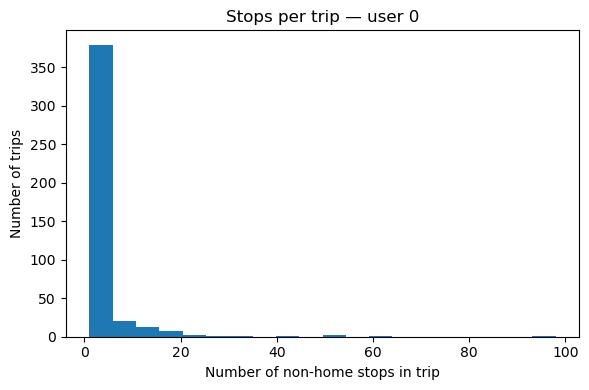

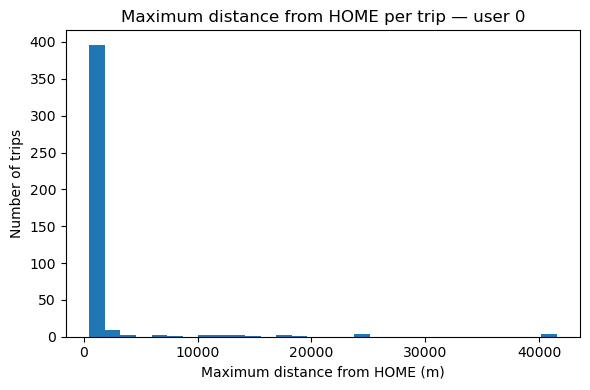

In [11]:
# Keep only visits that belong to a trip
vt_trip = visit_table[visit_table["trip_id"] > 0].copy()

trip_summary = (
    vt_trip
    .groupby(["person", "date", "trip_id"], as_index=False)
    .agg(
        n_stops=("action_order_in_trip", lambda x: (x > 0).sum()),
        trip_start=("first_dt", "min"),
        trip_end=("last_dt", "max"),
        max_dist_home=("dist_home_m", "max"),
        mean_dist_home=("dist_home_m", "mean"),
    )
)

trip_summary["trip_duration_min"] = (
    (trip_summary["trip_end"] - trip_summary["trip_start"])
    .dt.total_seconds() / 60.0
)

print("Number of trips:", len(trip_summary))
display(trip_summary.head())

# --- 3.1 Histogram of stops per trip ---
plt.figure(figsize=(6, 4))
plt.hist(trip_summary["n_stops"], bins=20)
plt.xlabel("Number of non-home stops in trip")
plt.ylabel("Number of trips")
plt.title(f"Stops per trip — user {USER_ID}")
plt.tight_layout()
plt.show()

# --- 3.2 Histogram of max distance from HOME per trip ---
plt.figure(figsize=(6, 4))
plt.hist(trip_summary["max_dist_home"], bins=30)
plt.xlabel("Maximum distance from HOME (m)")
plt.ylabel("Number of trips")
plt.title(f"Maximum distance from HOME per trip — user {USER_ID}")
plt.tight_layout()
plt.show()


For user 000 there are 429 identified home–home trips. The histogram of
n_stops shows that most trips are very simple: the median is one non-home
stop and the vast majority of outings contain only one or two stops, with a
long but thin right tail of unusually complex trips (up to nearly 100
recorded stops). The distribution of max_dist_home tells a similar story on
the spatial side. Most trips remain within a few kilometres of HOME, but
there are occasional long-distance excursions that reach tens of kilometres
away. Together, these summaries highlight a pattern of frequent short errands
around home punctuated by rare, much longer journeys.


## 4. Next-step behaviour within trips

### 4.1 Calculate the non home stops

The analysis now shifts from entire home–home trips to the individual non-home stops that occur within each trip. At each such stop, the key question becomes: what happens next? Rather than focusing on the whole sequence, we examine the immediate next step following each non-home visit.

Within each trip episode, three possible next-step outcomes are defined.
The first is home, meaning that the next recorded stop is a return to HOME.
The second is explore, in which the individual continues the trip by visiting another non-home location—this may be a SW, Pv, or Pn place.
The third is end, indicating that the trip terminates in the data and no further stop is observed.

A special rule is applied to the last non-home stop of each trip. When this final stop is labeled end, it often reflects the end of the day rather than a genuine termination of activity away from home. To avoid treating these end-of-day records as if the person remained out indefinitely, we reclassify an end outcome as effectively going home if the stop occurs late at night (hour ≥ 23) or is very close to HOME (within 750 m). This adjustment ensures that outcome categories are more comparable across different stops and reduces artificial inflation of “end” events.

After this reclassification, the resulting next-step outcomes are tabulated by the stop order 
𝑘
k within each trip. This tabulation describes how the relative frequencies of “go home,” “keep exploring,” and “end” evolve as a trip progresses, providing a clearer picture of within-trip behavioral dynamics.

In [6]:
MAXK = 30        # only consider the first 30 stops within each trip
NIGHT_HOUR = 23  # >= 23:00 considered "late"
NEAR_HOME_M = 750

# Non-home visits that are part of a trip and have a positive action order
vis = visit_table[
    (visit_table["is_home"] == 0) &
    (visit_table["trip_id"] > 0) &
    (visit_table["action_order_in_trip"] > 0)
].copy()

vis = vis[vis["action_order_in_trip"] <= MAXK].copy()

print("Non-home visit events inside trips:", len(vis))
print("\nRaw next_step value counts (non-home):")
print(vis["next_step"].value_counts())

# --- Classify next-step outcomes ---

vis["outcome"] = np.where(
    vis["next_step"] == "home", "home",
    np.where(vis["next_step"].isin(["sw", "pv", "pn"]), "explore", "end")
)

# Identify the last non-home visit of each trip
last_mask = vis.groupby(
    ["person", "date", "trip_id"]
).cumcount(ascending=False).eq(0)

# Late or near home?
last_time_dt = pd.to_datetime(vis["last_time"], format="%H:%M:%S", errors="coerce")
late = last_time_dt.dt.hour.ge(NIGHT_HOUR)
near = vis["dist_home_m"].le(NEAR_HOME_M)

# Reclassify terminal 'end' as 'home' if late or near HOME
vis.loc[
    last_mask & (vis["outcome"] == "end") & (late | near),
    "outcome"
] = "home"

print("\nOutcome counts after reclassification:")
print(vis["outcome"].value_counts())

# --- Outcome proportions by stop order k in trip ---

counts = (
    vis.groupby("action_order_in_trip")["outcome"]
       .value_counts()
       .unstack(fill_value=0)
       .reindex(range(1, MAXK + 1), fill_value=0)
)
counts["total"] = counts.sum(axis=1)

props = counts.div(
    counts["total"].where(counts["total"] > 0, np.nan),
    axis=0
)

print("\nOutcome composition (first 10 k):")
display(props[["explore", "home", "end"]].head(10))

Non-home visit events inside trips: 1306

Raw next_step value counts (non-home):
next_step
pn      632
home    338
pv      219
none     85
sw       32
Name: count, dtype: int64

Outcome counts after reclassification:
outcome
explore    883
home       403
end         20
Name: count, dtype: int64

Outcome composition (first 10 k):


outcome,explore,home,end
action_order_in_trip,,,
1,0.333333,0.657343,0.009324
2,0.874126,0.090909,0.034965
3,0.648000,0.328000,0.024000
4,0.901235,0.086420,0.012346
5,0.684932,0.301370,0.013699
6,0.880000,0.100000,0.020000
7,0.840909,0.113636,0.045455
8,0.918919,0.081081,0.000000
9,0.911765,0.088235,0.000000


For user `000` there are 1,306 non-home stops inside trips, of which 883 are
followed by another non-home place (explore), 403 by a return home, and only
20 end the trip without a further visit after the late/near-home
reclassification. The composition by stop order \(k\) shows a clear pattern:
at the **first** stop, going home is very common (around two thirds of trips
return home immediately and only one third continue to explore). Once a trip
survives this first stop, however, exploration dominates: for \(k = 2\) and
beyond, 65–90% of stops are followed by another non-home place and the hazard
of going home falls to around 10–30%. In other words, many trips are short
one-stop errands, but conditional on not going straight home, the user tends
to string together several exploratory stops before ending the outing.


### 4.2 Discrete-time hazard of going home
Within each trip, non-home stops are treated as discrete time steps: the first stop after leaving HOME, the second stop, the third stop, and so on. At each step, the analysis focuses on what happens next conditional on the trip having reached that point. For every step number \(k\), the data across all trips are pooled to compute two quantities: the total number of trips that have reached at least the \(k\)-th non-home stop, and, among those, the number of trips that return directly to HOME immediately after stop \(k\).

The ratio of these two counts defines the hazard of going home at step \(k\),

`h_k = P(go home next | trip has reached stop k)`,

which answers: *given that this trip has already made it to stop \(k\), what is the probability that the next move is to go home rather than continue exploring?* This discrete-time hazard summarizes how the immediate “go home now” tendency changes as the trip accumulates more non-home stops.

Based on the hazards, the analysis also derives the **survival probability** \(S_k\), defined as the probability that a trip is still ongoing after \(k\) non-home stops. In discrete time, this is obtained by multiplying \(1 - h_k)\ across successive steps, as the chance that the individual has not yet decided to return home. Intuitively, \(S_k\) represents the probability that the person is “still out” after making \(k\) stops away from home.

The first panel visualizes the empirical hazards \(h_k\) together with a simple logit trend in \(k\) fitted for \(k \ge 2\), showing how the propensity to go home varies with stop order. The second panel compares the empirical survival curve \(S_k\) with the corresponding model-based survival curve implied by the fitted hazard specification. Together, these plots illustrate how both the "go home now" probability and the "still out" probability evolve as trips become longer.

Hazard table (first 10 k):


,home_k,at_risk,hazard
1,282,429,0.657343
2,13,143,0.090909
3,41,125,0.328000
4,7,81,0.086420
5,22,73,0.301370
6,5,50,0.100000
7,5,44,0.113636
8,3,37,0.081081
9,3,34,0.088235
10,2,31,0.064516


Ks used in hazard fit: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
          Coef.  Std.Err.         z         P>|z|    [0.025   0.975]
const -1.217758  0.194916 -6.247605  4.167954e-10 -1.599786 -0.83573
x1    -0.092337  0.033081 -2.791279  5.250023e-03 -0.157174 -0.02750


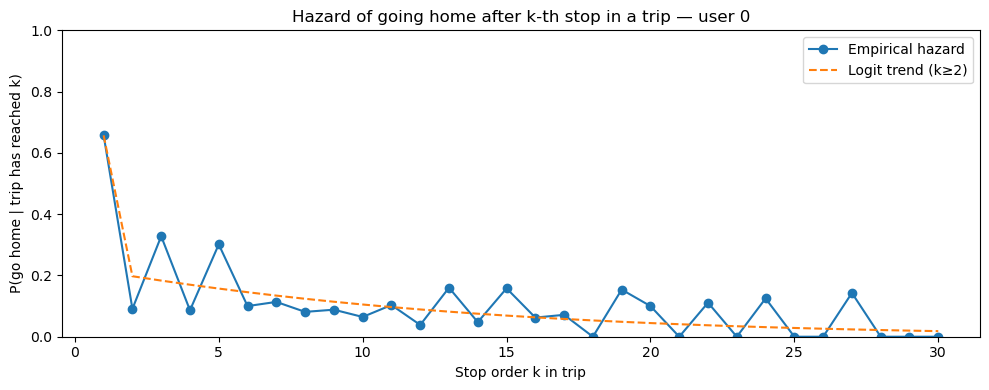

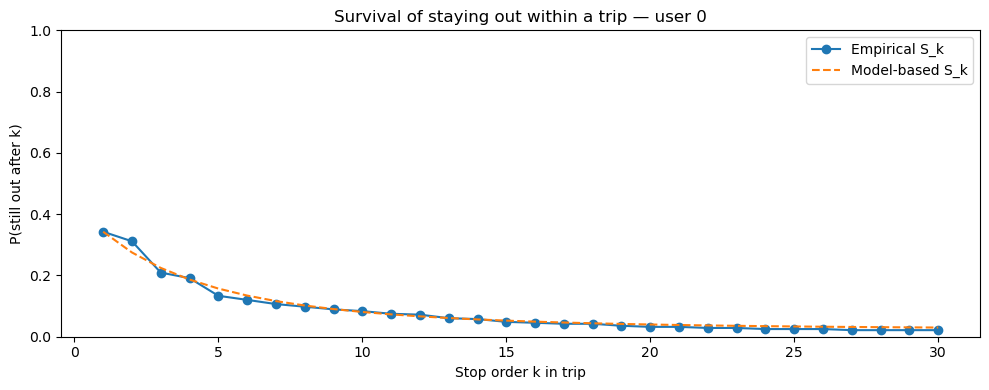

In [7]:
# Per-trip maximum stop order (within the MAXK truncation)
pertrip_maxk = (
    vis.groupby(["person", "date", "trip_id"])["action_order_in_trip"]
       .max()
)

# Risk set: number of trips that reach at least stop k
at_risk = pd.Series(
    {k: int((pertrip_maxk >= k).sum()) for k in range(1, MAXK + 1)},
    name="at_risk"
)

# Number of trips where the k-th stop is followed by "home"
home_k = (
    vis[vis["outcome"] == "home"]
    .groupby("action_order_in_trip")
    .size()
    .reindex(range(1, MAXK + 1), fill_value=0)
    .rename("home_k")
)

hazard = (home_k / at_risk.replace(0, np.nan)).rename("hazard")

haz_df = pd.concat([home_k, at_risk, hazard], axis=1)
print("Hazard table (first 10 k):")
display(haz_df.head(10))

# ---------- Empirical survival S_k ----------
k_axis = np.arange(1, MAXK + 1)
haz_vals_emp = hazard.reindex(k_axis).fillna(0).values

S_emp = []
s = 1.0
for hk in haz_vals_emp:
    s *= (1 - hk)
    S_emp.append(s)
S_emp = np.array(S_emp)

# ---------- Simple logit trend for hazard (k>=2) ----------
import statsmodels.api as sm

MIN_RISK = 20

haz_fit = (
    haz_df
    .loc[haz_df.index >= 2] 
    .loc[lambda df: df["at_risk"] >= MIN_RISK]
    .copy()
)

print("Ks used in hazard fit:", haz_fit.index.tolist())

k_fit = haz_fit.index.values.astype(float)
X = sm.add_constant(k_fit)

y = np.column_stack([
    haz_fit["home_k"].values,
    (haz_fit["at_risk"] - haz_fit["home_k"]).values
])

glm = sm.GLM(y, X, family=sm.families.Binomial())
res_haz = glm.fit()
print(res_haz.summary2().tables[1])

alpha = res_haz.params[0]
beta  = res_haz.params[1]

X_pred = sm.add_constant(k_axis[1:])
haz_hat_tail = res_haz.predict(X_pred)

h1_emp = haz_df.loc[1, "hazard"]
haz_hat = np.concatenate([[h1_emp], haz_hat_tail])

S_hat = []
s = 1.0
for hk in haz_hat:
    s *= (1 - hk)
    S_hat.append(s)
S_hat = np.array(S_hat)

# ---------- Plot hazard: empirical vs fitted ----------
plt.figure(figsize=(10, 4))
plt.plot(k_axis, haz_vals_emp, marker="o", label="Empirical hazard")
plt.plot(k_axis, haz_hat, linestyle="--", label="Logit trend (k≥2)")
plt.ylim(0, 1)
plt.xlabel("Stop order k in trip")
plt.ylabel("P(go home | trip has reached k)")
plt.title(f"Hazard of going home after k-th stop in a trip — user {USER_ID}")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot survival: empirical vs fitted ----------
plt.figure(figsize=(10, 4))
plt.plot(k_axis, S_emp, marker="o", label="Empirical S_k")
plt.plot(k_axis, S_hat, linestyle="--", label="Model-based S_k")
plt.ylim(0, 1)
plt.xlabel("Stop order k in trip")
plt.ylabel("P(still out after k)")
plt.title(f"Survival of staying out within a trip — user {USER_ID}")
plt.legend()
plt.tight_layout()
plt.show()


### 4.3 Within-Trip Exploration: When Do New Places (Pv) Appear?

The analysis now moves from going-home decisions to **exploration within a trip**. For every non-home stop, we know whether the location is a first-time place for the user (Pv) or a return to an already visited place (Pn).

To study how exploration changes as a trip unfolds, the stops are ordered by their position within the trip. For each stop number \(k\), the share of stops that are Pv is calculated. This produces an empirical curve showing how often new places appear at different stages of a trip.

For user `000`, about 18% of all non-home stops across trips are first-time places. The exploration rate is relatively low in the first few stops but gradually increases as the trip continues, reaching roughly 30% around the 8th to 10th stop. A simple logit regression, applied only to stop numbers with enough observations, provides the smooth trend line shown in the figure. The estimated effect suggests that each additional stop in a trip increases the odds of discovering a new place by around one quarter.



In [8]:
# Non-home visits inside trips (same base as for hazard)
vis_places = visit_table[
    (visit_table["is_home"] == 0) &
    (visit_table["trip_id"] > 0) &
    (visit_table["action_order_in_trip"] > 0)
].copy()

vis_places = vis_places[vis_places["action_order_in_trip"] <= MAXK].copy()

# Counts by stop order: how often is the stop Pv vs Pn?
pv_by_k = (
    vis_places
    .groupby("action_order_in_trip")[["is_pv", "is_pn"]]
    .agg(
        pv_cnt=("is_pv", "sum"),
        pn_cnt=("is_pn", "sum"),
        n=("is_pv", "size")
    )
    .reset_index()
)

pv_by_k["pv_rate"] = pv_by_k["pv_cnt"] / (
    pv_by_k["pv_cnt"] + pv_by_k["pn_cnt"]
).replace(0, np.nan)

overall_pv = vis_places["is_pv"].mean()

print("Overall share of first-time places (Pv) among non-home trip stops:",
      round(overall_pv, 3))
print("\nPv rate by stop order k (first 10 k):")
display(pv_by_k[["action_order_in_trip", "pv_rate"]].head(10))

Overall share of first-time places (Pv) among non-home trip stops: 0.181

Pv rate by stop order k (first 10 k):


,action_order_in_trip,pv_rate
0,1,0.097561
1,2,0.153285
2,3,0.126126
3,4,0.164557
4,5,0.144928
5,6,0.265306
6,7,0.279070
7,8,0.297297
8,9,0.272727
9,10,0.322581


Ks with n >= 30: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
               Coef.  Std.Err.          z         P>|z|    [0.025    0.975]
const      -2.074610  0.103630 -20.019307  3.738832e-89 -2.277722 -1.871498
k_centered  0.236422  0.031935   7.403330  1.328116e-13  0.173831  0.299013
Odds ratio for Pv per additional stop (n>=30): 1.267


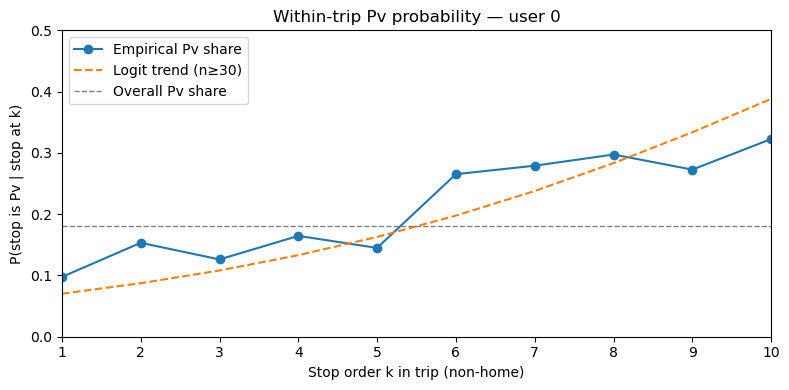

In [9]:
pv_by_k = pv_by_k.copy() 

MIN_N = 30
valid_k = pv_by_k.loc[pv_by_k["n"] >= MIN_N, "action_order_in_trip"]
print("Ks with n >= 30:", valid_k.tolist())

vis_lr_sub = vis_places[
    vis_places["action_order_in_trip"].isin(valid_k)
].copy()

vis_lr_sub["k_centered"] = (
    vis_lr_sub["action_order_in_trip"]
    - vis_lr_sub["action_order_in_trip"].mean()
)

X = sm.add_constant(vis_lr_sub["k_centered"])
y = vis_lr_sub["is_pv"]

logit_model = sm.Logit(y, X)
res = logit_model.fit(disp=False)
print(res.summary2().tables[1])

beta0 = res.params["const"]
beta1 = res.params["k_centered"]

odds_ratio = np.exp(beta1)
print(f"Odds ratio for Pv per additional stop (n>={MIN_N}): {odds_ratio:.3f}")

k_max = int(valid_k.max())
k_grid = np.arange(1, k_max + 1)
k_grid_c = k_grid - vis_lr_sub["action_order_in_trip"].mean()
lin_pred = beta0 + beta1 * k_grid_c
p_hat = 1 / (1 + np.exp(-lin_pred))

pv_plot = pv_by_k[pv_by_k["action_order_in_trip"] <= k_max]

plt.figure(figsize=(8,4))
plt.plot(
    pv_plot["action_order_in_trip"],
    pv_plot["pv_rate"],
    marker="o",
    label="Empirical Pv share"
)
plt.plot(
    k_grid,
    p_hat,
    linestyle="--",
    label=f"Logit trend (n≥{MIN_N})"
)
plt.axhline(
    overall_pv,
    color="gray",
    linestyle="--",
    linewidth=1,
    label="Overall Pv share"
)
plt.ylim(0, 0.5)
plt.xlim(1, k_max)
plt.xlabel("Stop order k in trip (non-home)")
plt.ylabel("P(stop is Pv | stop at k)")
plt.title(f"Within-trip Pv probability — user {USER_ID}")
plt.legend()
plt.tight_layout()
plt.show()


### 4.4 Behavioural summary

- Everyday mobility is dominated by short, nearby home–home trips. Most outings contain only a few non-home stops, and the typical activity radius is tightly clustered around HOME; long-distance excursions show up as rare outliers.

- Within a single trip, there is a large mass of “one-stop errands” that return straight home, producing a very high probability of going home after the first stop. Conditional on surviving this initial stage, the per-stop hazard of returning home declines with stop order: once a trip has been running for a while, the person becomes increasingly “sticky” to staying out.

- Along the same trip, early stops are mostly revisits to familiar locations, whereas the share of first-time places (Pv) rises steadily with stop order. Exploration is therefore concentrated in the middle and later parts of a trip, once the outing has “warmed up”.

Taken together, these patterns can be summarised as follows: most days involve short errands close to home; when a longer outing does occur, the person tends to stay out for a while and becomes progressively more likely to explore new places.

